# Plos Pipeline

## Algorithm
#### Description
The PLOS Pipeline algorithm intends to convert a multiplex flourescence microscopy or immunoflourescence array topography volume to a probability volume representing the probability that any single voxel is a synapse. For our purposes, we will be utilizing the first 3 steps of this pipeline, namely:
1. Computation of Foreground Probability
2. Probability of 2D Puncta
3. Probability of 3D Puncta

#### Inputs
A 3-D image volume obtained through In-vivo two photon SEP-GluA1 imaging.

#### Outputs
A probability volume representing the probability that any one voxel in the volume is a synapse

#### Function

In [52]:
######################################
###THIS IS PSEUDOCODE; WILL NOT RUN###
######################################

###STEP 1: COMPUTATION OF FOREGROUND PROBABILITY###
cdfMapVolume = []
for image in volume:
    
    #Get a distribution of intensities of the slice
    dist = generateDistribution(image)
    
    #Get the cdf for every voxel in the image slice
    cdfMap = zeros_like(dist)
    for y in image.height:
        for x in image.width:
            cdfMap[y][x] = dist.cdf(image[y][x])
    cdfMapVolume.apend(cdfMap)
    
####Step 2: Probability of 2D Puncta
filteredVolume = zeros_like(cdfMapVolume)
for z in cdfMapVolume.depth:
    for y in cdfMapVolume.height:
        for x in cdfMapVolume.width:
            #NOTE: boxFilter apples a box filter(duh...) of size at the given zyx
            #this boxFilter is equivalent to the product of all elements that are <=size
            #away from the zyx center, and are on the same z slice.
            filteredVolume[z][y][x] = boxFilter(cdfMapVolume, z, y, x, size)
            
####Step 3: Probability of 3D Puncta
finalVolume = zeros_like(filteredVolume)
for z in filteredVolume.depth:
    for y in filteredVolume.height:
        for x in filteredVolume.width:
            #getSquaredError calculates the sum of the squared error between the provided zyx voxel
            #and the voxel at the same yx points within size distance of z (i.e. up and down z axis)
            finalVolume[z][y][x] = filteredVolume[z][y][x] * exp(-1 * getSquaredError(filteredVolume, z, y, x, size))

NameError: name 'volume' is not defined

## Write Code
All code for this PLOS Pipeline can be found in our plosLib.py file, located here:

https://github.com/NeuroDataDesign/pan-synapse/blob/master/code/functions/plosLib.py


## Simulation
### 1.Unit Testing
Unit tests were developed to validate the functionality and correctness of all major functions within the PLOS Pipeline. These tests can be found here:

https://github.com/NeuroDataDesign/pan-synapse/tree/master/code/tests

Relevant unit tests for the PLOS pipeline include:
- generate2PunctaMapTest.py
- prodConvTest.py
- generateForegroundProbMapTest.py
- interVoxSquaredErrorTest.py

### 2.Pipeline Functionality Testing
Pipeline Functionality Tests will be performed to demonstrate that the pipeline performs as expected under perfectly ideal and perfectly non-ideal circumstances. Data will be sampled from two synthetic sets, one with two 3x3x3 'synapse' clusters of intensity 100 within a 20x20x20 volume, and one of uniform data with value 100 within a 20x20x20 volume.

#### Success
- We expect the pipeline to identify a high probability of synapse for the two clusters in the synthetic synapse data

#### Failure
- We expect the pipeline to identify the entire volume as a high probability of synapse for the uniform data since there is no variance in the data.

#### 1. Generate Functionality Data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import sys
sys.path.insert(0,'../code/functions/')

twoClusterDat = pickle.load(open('../code/tests/synthDat/twoPerfectClusters.synth'))
all100Dat = pickle.load(open('../code/tests/synthDat/all100.synth'))

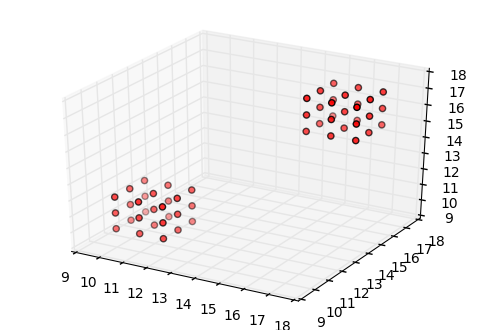

In [4]:
#The two cluster data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = twoClusterDat.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

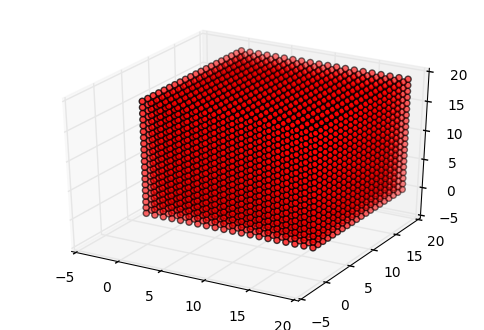

In [5]:
#The uniform data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = all100Dat.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

In [5]:
#Get the implemented library code
import plosLib as pLib
import connectLib as cLib

In [7]:
twoClusterResults = pLib.pipeline(twoClusterDat)
bianTwoClusterResults = cLib.otsuVox(twoClusterResults)

/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1728: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


#### 2.Generate Functionality Results

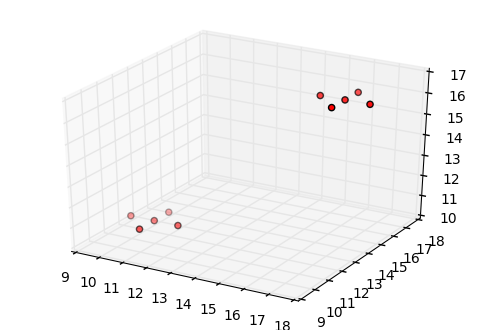

In [8]:
#The binary two cluster results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = bianTwoClusterResults.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

In [9]:
uniformResults = pLib.pipeline(all100Dat)
bianUniformResults = cLib.otsuVox(uniformResults)

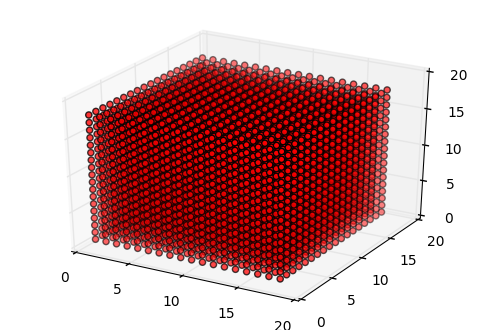

In [10]:
#The binary two cluster results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = uniformResults.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

#### 3. Analyze Functionality Results

The results above are consistent with the provided hypothesis. The algorithm performed well on the well separated, highly variant data, and poorly on the non-separated, invariant data. Thus, we can procede to run validation testing on the pipeline

### 3. Validation Testing
#### Success
#### 1.Generate Data
The following code will generate a 100x100x100 volume with a pixel intensity distribution approximately the same as that of the true image volumes (i.e., 98% noise, 2% synapse). The synapse pixels will be grouped together in clusters as they would in the true data. Based on research into the true size of synapses, these synthetic synapse clusters will be given area of ~.2 microns ^3, or about 27 voxels (assuming the synthetic data here and the real world data have identical resolutions). The following metrics will be calculated to gauge performance: 

1. Probability of Detection (PD) will be calculated based on how many true synapse points the algorithm detects after the binarization step. A synapse is deteted if any point in its volume is given a score of 1 post-binarization

2. False Alarm Rate (FAR) will be calculated based on how many points are scored with a 1, post-binarization, that do not correspond with any point in the volume of a synapse cluster

These metrics will be calculated for both the pipeline, and a randomly generated label set, for each test.

In [2]:
from random import randrange as rand
from skimage.measure import label

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 2):
        for y in range(-1, 2):
            for x in range(-1, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume, noiseVolume



def executeTest():
    trueVolume, testVolume = generateTestVolume()
    labelVolume = label(trueVolume)
    maxLabel = np.max(labelVolume)
    
    #get pieline results
    results = cLib.otsuVox(pLib.pipeline(testVolume))
    detected = zip(*np.where(results == 1))
    
    #get random results for p value comparison
    randomResults = np.zeros_like(testVolume)
    for z in range(randomResults.shape[0]):
        for y in range(randomResults.shape[1]):
            for x in range(randomResults.shape[2]):
                randomResults[z][y][x] = rand(0, 2)
    randomDetected = zip(*np.where(randomResults == 1))
    
    #score results
    numDetected = 0
    numMistaken = 0
    alreadyCounted = []
    for point in detected:
        labelPointVal = labelVolume[point[0], point[1], point[2]]
        if labelPointVal != 0 and not labelPointVal in alreadyCounted:
            numDetected +=1
            alreadyCounted.append(labelPointVal)
        if labelPointVal == 0:
            numMistaken +=1
            
    print "\tPipeline:"
    print "\t\tPD: ", float(numDetected)/maxLabel
    print "\t\tFAR: ", float(numMistaken)/(100 * 100 *100)
    
    randNumDetected = 0
    randNumMistaken = 0
    alreadyCounted = []
    for point in randomDetected:
        labelPointVal = labelVolume[point[0], point[1], point[2]]
        if labelPointVal != 0 and not labelPointVal in alreadyCounted:
            randNumDetected +=1
            alreadyCounted.append(labelPointVal)
        if labelPointVal == 0:
            randNumMistaken +=1
    
    print "\tRandom:"
    print "\t\tPD: ", float(randNumDetected)/maxLabel
    print "\t\tFAR: ", float(randNumMistaken)/(100 * 100 *100)
    
    return float(numDetected)/maxLabel, float(numMistaken)/(100 * 100 *100), float(randNumDetected)/maxLabel, float(randNumMistaken)/(100 * 100 *100)
    

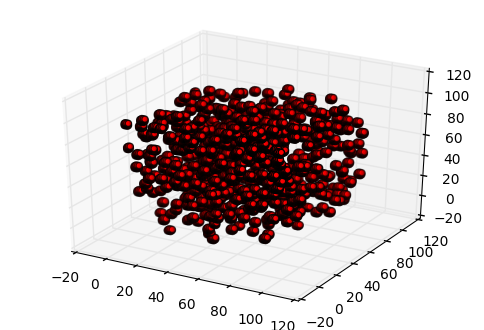

In [6]:
test, noiseTest = generateTestVolume()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = test.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

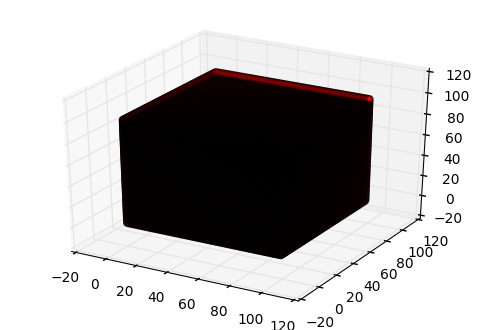

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = noiseTest.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

#### 2.Generate Results

In [8]:
spd=0.
sfar=0.
srpd=0.
srfar=0.

for num in range(1,11):
    print "\nExecuting Test: ", num
    pd, far, rpd, rfar = executeTest()
    spd+=pd
    sfar+=far
    srpd+=rpd
    srfar+=rfar

print '\n\nAverage Performance:'
print '\tPipeline:'
print '\t\tPD: ', spd/10.
print '\t\tFAR: ', sfar/10.
print '\tRandom: '
print '\t\tPD: ', srpd/10.
print '\t\tFAR: ', srfar/10.


Executing Test:  1
	Pipeline:
		PD:  0.972337482711
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.489211

Executing Test:  2
	Pipeline:
		PD:  0.970802919708
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.49215

Executing Test:  3
	Pipeline:
		PD:  0.970149253731
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.489694

Executing Test:  4
	Pipeline:
		PD:  0.988439306358
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.492672

Executing Test:  5
	Pipeline:
		PD:  0.980582524272
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.48886

Executing Test:  6
	Pipeline:
		PD:  0.982
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.493405

Executing Test:  7
	Pipeline:
		PD:  0.973063973064
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.492012

Executing Test:  8
	Pipeline:
		PD:  0.983483483483
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.490395

Executing Test:  9
	Pipeline:
		PD:  0.97628458498
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  0.492843

Executing Test:  10
	Pipeline:
		PD:  0.988555078684
		FAR:  0.0
	Random:
		PD:  1.0
		FAR:  

#### 3. Analyze Results
Comparative to the random sampling, the actual pipeline performs ~2.2% worse in probability of detection, but has ~49% less false alarms, on average.

Some intuition behind these numbers:

- The size of volume of test synapses is 27 voxels, meaning that the random algorithm has a $1-(.5)^{27} = .999$ probability of labeling at least one voxel in the volume as true. This explains the very high PD for the random algorithm.

- The FAR of the random algorithm has a similarly simple intuition. Since 98% of the volume is 'not synapse', and the randomized algorithm has a 50% chance of labeling any one voxel as 'synapse' there is a $.98*.5=.49$ probability that it marks an incorrect voxel as correct.

- The PD of the pipeline is hovering around 98%. I believe that the reason for this not being at 100 is that the algorithm does not attempt to classify voxels where any part of the computations in its pipeline are undefined. Due to this, it will not report a true positive on synapses that are in the corners or on the edges of the volume. I intend to write a test suite to evaluate this hypothesis in the near future. 

- The FAR of the pipeline is extemely low at 0%. Under normal circumstances, this would provide evidence that hyperparameters could be tweaked such that one could increase the PD at little to no cost in FAR. However, the current default hyperparameter set is the smallest set that can be applied to this particular algorithm; meaning that it cannot be tweaked to favor detection over false alarms any more than it already is. With this in mind, we could make a few modifications to the algorithm to optimize it to the circumstances at hand. I intend to test these tweaks once the full pipeline is together and functional.

#### Failure

#### 1. Generate Data
Since the heavily blurs the image through its repeated use of box filters and nearest neighbor calculations, it should perform very poorly on clusters that are unusually small (i.e., 4x4 and 1x4). The following code will generate clusters of this type, and then run the same scoring analysis as above on them.

In [11]:
def generateSmallPointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = [center]       
    return set(toPopulate)                       

                    
def generateSmallTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generateSmallPointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
        
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
        
    return volume, noiseVolume

def executeFailureTest():
    trueVolume, testVolume = generateSmallTestVolume()
    labelVolume = label(trueVolume)
    maxLabel = np.max(labelVolume)
    
    #get pieline results
    results = cLib.otsuVox(pLib.pipeline(testVolume))
    detected = zip(*np.where(results == 1))
    
    #get random results for p value comparison
    randomResults = np.zeros_like(testVolume)
    for z in range(randomResults.shape[0]):
        for y in range(randomResults.shape[1]):
            for x in range(randomResults.shape[2]):
                randomResults[z][y][x] = rand(0, 2)
    randomDetected = zip(*np.where(randomResults == 1))
    
    #score results
    numDetected = 0
    numMistaken = 0
    alreadyCounted = []
    for point in detected:
        labelPointVal = labelVolume[point[0], point[1], point[2]]
        if labelPointVal != 0 and not labelPointVal in alreadyCounted:
            numDetected +=1
            alreadyCounted.append(labelPointVal)
        if labelPointVal == 0:
            numMistaken +=1
            
    print "\tPipeline:"
    print "\t\tPD: ", float(numDetected)/maxLabel
    print "\t\tFAR: ", float(numMistaken)/(100 * 100 *100)
    
    randNumDetected = 0
    randNumMistaken = 0
    alreadyCounted = []
    for point in randomDetected:
        labelPointVal = labelVolume[point[0], point[1], point[2]]
        if labelPointVal != 0 and not labelPointVal in alreadyCounted:
            randNumDetected +=1
            alreadyCounted.append(labelPointVal)
        if labelPointVal == 0:
            randNumMistaken +=1
    
    print "\tRandom:"
    print "\t\tPD: ", float(randNumDetected)/maxLabel
    print "\t\tFAR: ", float(randNumMistaken)/(100 * 100 *100)
    
    return float(numDetected)/maxLabel, float(numMistaken)/(100 * 100 *100), float(randNumDetected)/maxLabel, float(randNumMistaken)/(100 * 100 *100)
    

#### 2. Generate Results

In [12]:
spd=0.
sfar=0.
srpd=0.
srfar=0.

for num in range(1,11):
    print "\nExecuting Test: ", num
    pd, far, rpd, rfar = executeFailureTest()
    spd+=pd
    sfar+=far
    srpd+=rpd
    srfar+=rfar

print '\n\nAverage Performance:'
print '\tPipeline:'
print '\t\tPD: ', spd/10.
print '\t\tFAR: ', sfar/10.
print '\tRandom: '
print '\t\tPD: ', srpd/10.
print '\t\tFAR: ', srfar/10.


Executing Test:  1
	Pipeline:
		PD:  0.0319361277445
		FAR:  0.012378
	Random:
		PD:  0.443113772455
		FAR:  0.50091

Executing Test:  2
	Pipeline:
		PD:  0.0282186948854
		FAR:  0.012296
	Random:
		PD:  0.513227513228
		FAR:  0.500221

Executing Test:  3
	Pipeline:
		PD:  0.0318791946309
		FAR:  0.01252
	Random:
		PD:  0.476510067114
		FAR:  0.498682

Executing Test:  4
	Pipeline:
		PD:  0.0456375838926
		FAR:  0.013637
	Random:
		PD:  0.510067114094
		FAR:  0.499835

Executing Test:  5
	Pipeline:
		PD:  0.0339673913043
		FAR:  0.013391
	Random:
		PD:  0.527173913043
		FAR:  0.499485

Executing Test:  6
	Pipeline:
		PD:  0.0377867746289
		FAR:  0.014397
	Random:
		PD:  0.452091767881
		FAR:  0.50029

Executing Test:  7
	Pipeline:
		PD:  0.0285714285714
		FAR:  0.013719
	Random:
		PD:  0.495238095238
		FAR:  0.499787

Executing Test:  8
	Pipeline:
		PD:  0.0418848167539
		FAR:  0.01302
	Random:
		PD:  0.528795811518
		FAR:  0.500281

Executing Test:  9
	Pipeline:
		PD:  0.041186161449

#### 3. Analyze Results
As expected the pipeline performed very poorly on the small synapse data. 
